In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from scipy.interpolate import interp1d
from matplotlib.ticker import FormatStrFormatter
from svgpath2mpl import parse_path
from scipy import signal

%matplotlib inline

In [2]:
DURATION_SHORTS = 61
DURATION_LONG = 600

def getCategoryLabel(k):
    lbs = k.split(" ")
    if len(lbs) > 1:
        lb = ''.join([l[0] if l[0] != '&' else '' for l in lbs])
    else:
        lb = lbs[0][:2]
    return lb

In [3]:
data_df = pd.read_csv("../dataset/bilibili.csv",
            dtype={"id": "string", "publishedAt": "string",
                "title": "string", "categoryId": "string",
                "duration": int, "viewCount": int, 
                "countryCode": "string", "date": "string", "retentionCurve": "string"})

#age_df = pd.read_csv("../dataset/youtube_video_age.csv")

In [4]:
data_df

,id,publishedAt,title,categoryId,duration,viewCount,countryCode,date,retentionCurve
0,BV1F8411V7MG,2022-12-10T05:00:17Z,“究竟什么样的人，才会喜欢这种氛围感”,life,139,1663980,CN,,"M 0 100 L 0 80 C 7.0 80.0, 7.0 80.0, 14.1 80.0..."
1,BV128411G7by,2022-12-10T03:00:00Z,《下一个是谁》第四季（1）,life,2762,3155432,CN,,"M 0 100 L 0 80 C 5.1 80.0, 5.1 75.9, 10.1 75.9..."
2,BV19R4y1r73j,2022-12-12T02:44:40Z,压力怪给老子死,life,206,2554961,CN,,"M 0 100 L 0 80 C 7.1 80.0, 7.1 71.6, 14.3 71.6..."
3,BV1kP411M7fv,2022-12-06T04:15:40Z,当我穿上老婆婆的衣服去奶奶家，最后笑的站不来了,life,535,5049074,CN,,"M 0 100 L 0 80 C 5.6 80.0, 5.6 72.3, 11.1 72.3..."
4,BV1CW4y1M7fX,2022-12-10T20:01:29Z,帝后两不疑,life,187,931222,CN,,"M 0 100 L 0 80 C 5.3 80.0, 5.3 80.0, 10.5 80.0..."
...,...,...,...,...,...,...,...,...,...
30132,BV1sm4y1t7Xx,2023-05-23T21:33:57Z,四人都好美！aespa亮相戛纳晚宴,ent,83,151996,CN,,"M 0 100 L 0 80 C 5.8 80.0, 5.8 80.0, 11.6 80.0..."
30133,BV1wo4y1G7fp,2023-05-20T02:00:54Z,汤唯戛纳街头奔跑，像极了电影画面,ent,26,212799,CN,,"M 0 100 L 0 80 C 17.2 80.0, 17.2 80.0, 34.5 80..."
30134,BV1Ps4y1u7f5,2023-05-21T04:21:44Z,冨冨得正,ent,65,150334,CN,,"M 0 100 L 0 80 C 7.2 80.0, 7.2 80.0, 14.5 80.0..."
30135,BV1zL411B7Sm,2023-05-23T10:53:47Z,【浪姐4】一公reaction③ 前方高甜!能不能一直叮当不要停?! 就是最后投票好疑惑,ent,2187,111994,CN,,"M 0 100 L 0 80 C 5.0 80.0, 5.0 38.2, 10.0 38.2..."


In [5]:
for index, entry in data_df.iterrows():
    entry['categoryId'] = entry['categoryId'].capitalize()
    if entry['categoryId'] == 'Ent':
        entry['categoryId'] = "Entertainment"
    if entry['categoryId'] == 'Game':
        entry['categoryId'] = "Gaming"
    data_df.at[index, 'categoryId'] = entry['categoryId']

In [6]:
## YouTube shorts (<= 60s)
duration_by_country, duration_by_category = {}, {}
a = []
for index, entry in data_df.iterrows():
    region = duration_by_country.get(entry['countryCode'], [0, 0, 0])
    category = duration_by_category.get(entry['categoryId'], [0, 0, 0])
    
    region[2] += 1
    category[2] += 1
    if entry['duration'] > DURATION_LONG:
        region[0] += 1
        category[0] += 1
    elif entry['duration'] > DURATION_SHORTS and entry['duration'] <= DURATION_LONG:
        region[1] += 1
        category[1] += 1
    if entry['categoryId'] not in a:
        a.append(entry['categoryId'])
    duration_by_country[entry['countryCode']] = region
    duration_by_category[entry['categoryId']] = category

In [7]:
def plot_stacks(categoryIds, degree=70,
                size=(24,5), classes=['Bilibili (10+ mins)', 
                                      'Bilibili ($\leq$ 10 mins)', 
                                      'Bilibili ($\leq$ 60 secs)']):
    width = 0.35
    fig = plt.figure(figsize=size)
    plt.rcParams.update({'font.size': 22})
    plt.rcParams.update({'font.weight': 'bold'})
    plt.rcParams.update({'font.family': 'sans-serif'})
    plt.rcParams.update({'font.sans-serif': 'Verdana'})
    plt.rcParams.update({'pdf.fonttype': 42})
    plt.rcParams.update({'ps.fonttype': 42})

    data_tmp = {'Category': categoryIds}
    for idx, (title, data) in enumerate(data_tmp.items()):
        ax = fig.add_subplot(1, 2, idx+1)
        labels, greater, less, longs, greats = [], [], [], [], []
        for k, v in data.items():
            long, great = v[0]/v[2], v[1]/v[2]
            labels.append(getCategoryLabel(k))
            longs.append(long)
            greater.append(long+great)
            greats.append(great)
            less.append(1-long-great)
        greater, labels, less, longs, greats = zip(*sorted(
            zip(greater, labels, less, longs, greats), key=lambda x: (x[3], x[0])))
        ax.bar(labels, longs, width, label=classes[0], hatch='//', color='#7B68EE')
        ax.bar(labels, greats, width, bottom=longs, label=classes[1], hatch='\\', color='#DAA520')
        ax.bar(labels, less, width, bottom=greater, label=classes[2], hatch='/', color='#20B2AA')

        if idx == 0: ax.set_ylabel('Normalized Counts', fontsize=20, fontweight='bold')
        #ax.set_title(title, fontsize=22, fontweight='bold')
        #ax.legend(fontsize=20, loc='lower right')
        handles, labels = plt.gca().get_legend_handles_labels()
        order = [2, 1, 0]
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=20, loc='center right')
        
        ax.grid(linestyle=":")
        ax.tick_params(axis="both", labelsize=20)
        #plt.setp(ax.get_xticklabels(), rotation=degree, horizontalalignment='right')
        if idx == 0: plt.text(-2.55, -0.12, title, fontsize=20, fontweight='bold')
        else: plt.text(-3, -0.12, title, fontsize=20, fontweight='bold')
    plt.tight_layout()
    #plt.savefig('../artifacts/video_length.pdf', format='pdf', bbox_inches='tight', pad_inches=0.01)
    plt.show()

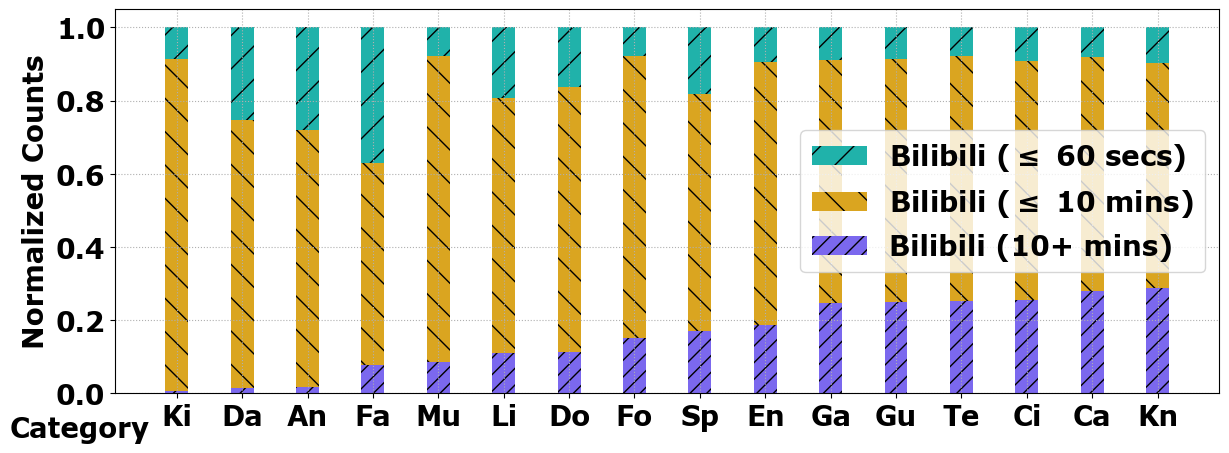

In [8]:
## 2.2.2 Video Length
plot_stacks(duration_by_category)

#### Q2: YouTube Shorts (<= 60s)
* Shorts are very popular in PK and VN.
* At least 20% of videos of PA (Pets & Animals) and Co (Comedy) are Shorts.

We are interested in `long` videos (> 60s).

In [9]:
def convertToPoints(svg_path, duration, debug=False):
    path = parse_path(svg_path)
    coordinates = np.array(path.to_polygons(closed_only=False))
    coordinates[0][:,1] = 100.0-coordinates[0][:,1]
    data = coordinates.T[:,:,0].tolist()
    x, y = data[0]/np.max(data[0])*duration, data[1]
    f = interp1d(x, y)
    xnew = np.arange(0, duration)
    ynew = f(xnew)
    return ynew.tolist()

In [10]:
xnew = np.arange(0, 1, 0.1)+0.1
auc_by_country, auc_by_category = {}, {}

for index, entry in data_df.iterrows():
    country = auc_by_country.get(entry['countryCode'], [])
    category = auc_by_category.get(entry['categoryId'], [])
    if entry['duration'] > DURATION_SHORTS:
    #if entry['duration'] <= DURATION_SHORTS and entry['duration'] > 5:
        curve = convertToPoints(entry['retentionCurve'], entry['duration'])[1:]
        n = len(curve)
        x = np.array([(i+1)/n for i in range(n)])
        y = np.array(curve)
        f = interp1d(x, y, fill_value="extrapolate")
        ynew = f(xnew)
        ynew[ynew < 0] = 0
        ynew = ynew.tolist()
        region.append(ynew)
        category.append(ynew)
        auc_by_country[entry['countryCode']] = country
        auc_by_category[entry['categoryId']] = category

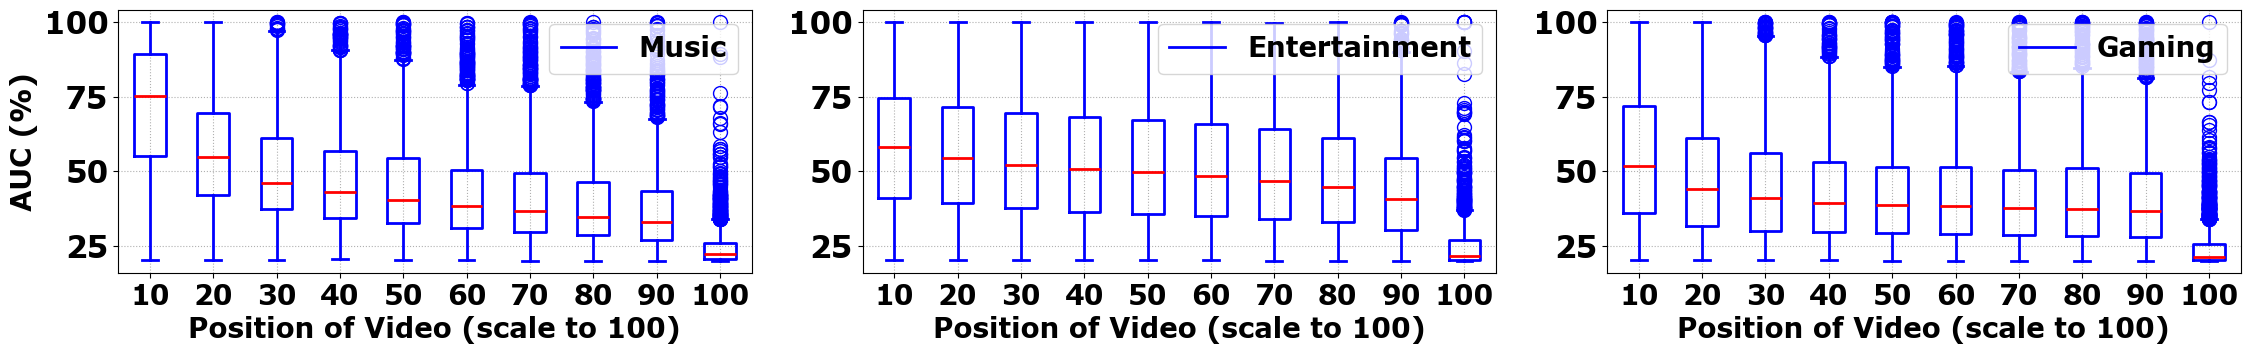

In [11]:
## 2.2.3 Area under Audience Retention Curve (AUC)
topn = 1
fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [2, 2, 2]}, 
                       figsize=(23,4))
#fig.tight_layout()
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams.update({'font.sans-serif': 'Verdana'})
plt.rcParams.update({'pdf.fonttype': 42})
plt.rcParams.update({'ps.fonttype': 42})
for idx, key in enumerate(['Music', 'Entertainment', 'Gaming']):
    ary = np.array(auc_by_category[key])
    bp1 = ax[idx].boxplot(ary, boxprops=dict(linewidth=2.0, color='blue'), 
        whiskerprops=dict(linewidth=2.0, color='blue'),
        medianprops=dict(linewidth=2.0, color='red'),
        capprops=dict(linewidth=2.0, color='blue'),
        flierprops=dict(marker='o', markersize=10,
        linestyle='none', markeredgecolor='b'))
    if idx == 0:
        ax[idx].set_ylabel("AUC (%)", fontsize=20, fontweight='bold')
    ax[idx].set_xlabel("Position of Video (scale to 100)", fontsize=20, fontweight='bold')
    ax[idx].set_xticklabels([(i+1)*10 for i in range(10)], fontsize=20, fontweight='bold')
    #ax[idx].set_ylim([-5, 100])
    ax[idx].legend([bp1["boxes"][0]], [key], fontsize=20, loc='upper right')
    ax[idx].grid(linestyle=":")

plt.tight_layout()
#plt.savefig('../artifacts/norm_video_length.pdf', format='pdf', bbox_inches='tight', pad_inches=0.01)
#plt.savefig('../artifacts/norm_video_length_short.pdf', format='pdf', bbox_inches='tight', pad_inches=0.01)
plt.show()

In [13]:
peak_by_country, peak_by_category = {}, {}
peaks = {}
widths = np.arange(10,100)
for index, entry in data_df.iterrows():
    if entry['duration'] > DURATION_SHORTS:
        #country = peak_by_country.get(entry['countryCode'], {})
        category = peak_by_category.get(entry['categoryId'], {})
        if entry['id'] in peaks.keys():
            n_peak = peaks[entry['id']]
        else:
            curve = convertToPoints(entry['retentionCurve'], entry['duration'])
            peakind = signal.find_peaks_cwt(curve, widths)
            n_peak = len(peakind)
            peaks[entry['id']] = n_peak
        
        #country[n_peak] = country.get(n_peak, 0) + 1
        category[n_peak] = category.get(n_peak, 0) + 1
        #peak_by_country[entry['countryCode']] = country
        peak_by_category[entry['categoryId']] = category
        if index % 10000 == 0: print("finished {}".format(index))

finished 0
finished 10000
finished 20000
finished 30000


In [20]:
def getCounts(peak_by_category, COUNT=6, INDEX=None):
    results = {}
    for k, v in peak_by_category.items():
        counts = [0 for i in range(COUNT)]
        for peak, count in v.items():
            if peak >= COUNT:
                counts[COUNT-1] += count
            else:
                counts[peak-1] += count
        results[k] = np.array(counts)/np.sum(counts)
    if INDEX == None:
        results = dict(sorted(results.items(), key=lambda item: item[1][COUNT-1]))
    else:
        results = dict(sorted(results.items(), key=lambda item: np.sum(item[1][INDEX:])))
    #print(results)
    return results

def plotPeakStack(plot_sets, size=(12,4), width=0.35, COUNT=6,
                  UNIT="spike", LOC='upper right', NCOL=2):
    fig = plt.figure(figsize=size)
    plt.rcParams.update({'font.size': 22})
    plt.rcParams.update({'font.weight': 'bold'})
    plt.rcParams.update({'font.family': 'sans-serif'})
    plt.rcParams.update({'font.sans-serif': 'Verdana'})
    plt.rcParams.update({'pdf.fonttype': 42})
    plt.rcParams.update({'ps.fonttype': 42})

    cls = [('0.5', None), ('#80D8FF', '/'), ('#F4FF81', '\\'),
           ('#FF80AB', '//'), ('#FFD180', '\\'), ('#E0E0E0', '/')]
    for index, (title, data) in enumerate(plot_sets.items()):
        # sort data
        ax = fig.add_subplot(1, len(plot_sets), 1+index)
        labels, counts = [], np.zeros((COUNT, len(data)))
        for idx, (k, v) in enumerate(data.items()):
            labels.append(getCategoryLabel(k))
            for i in range(len(v)):
                counts[i, idx] = v[i]
        for idx in range(COUNT):
            classes = "{} {}".format(idx+1, UNIT)
            if idx > 0: classes += 's'
            if idx == COUNT-1: classes = '{}+ {}s'.format(idx+1, UNIT)
            if idx == 0:
                ax.bar(labels, counts[idx,:], width, label=classes,
                       ls='--', edgecolor='black', error_kw=dict(capsize=12),
                       hatch=cls[idx][1], color=cls[idx][0])
            else:
                ax.bar(labels, counts[idx,:], width, bottom=np.sum(counts[:idx,:], axis=0),
                       ls='--', edgecolor='black', error_kw=dict(capsize=12),
                       label=classes, hatch=cls[idx][1], color=cls[idx][0])
        ax.grid(linestyle=":")
        if index == 0: ax.set_ylabel('Normalized Counts', fontsize=20, fontweight='bold')
        #ax.set_title(title, fontsize=22, fontweight='bold')
        ax.legend(fontsize=20, loc=LOC, ncol=int(COUNT/NCOL))
        ax.tick_params(axis="both", labelsize=20)
        #plt.setp(ax.get_xticklabels(), rotation=degree, horizontalalignment='right')
        if index == 0: plt.text(-2.7, -0.1, title, fontsize=20, fontweight='bold')
        else: plt.text(-1, -1, title, fontsize=20, fontweight='bold')
        #plt.ylim([0, 1.13])
    plt.tight_layout()
    #plt.savefig('../artifacts/video_spikes.pdf', format='pdf', bbox_inches='tight', pad_inches=0.01)
    plt.show()
    
peak_show_by_category = getCounts(peak_by_category)
#peak_show_by_country = getCounts(peak_by_country)

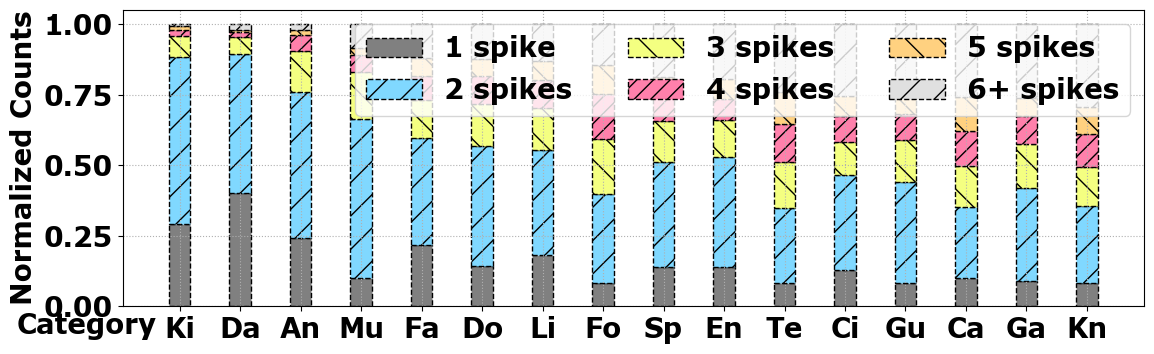

In [21]:
## 2.2.4 Spikes of Retention Curve
plot_sets = {}
plot_sets['Category'] = peak_show_by_category
#plot_sets['Country'] = peak_show_by_country
plotPeakStack(plot_sets)